## 1. 处理数据集

In [1]:
import numpy as np
import pandas as pd
import torch
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, IterableDataset
from torchvision import transforms
from transformers import BertTokenizer

EMOTION2ID = {"positive": 0, "neutral": 1, "negative": 2, "null": 3}
ID2EMOTION = {0: "positive", 1: "neutral", 2: "negative", 3: "null"}
SEED = 42

dataset_loc = "/kaggle/input/lab5-dataset/dataset"


class MultimodalDataset(IterableDataset):
    def __init__(self, samples, tokenizer):
        self.data = samples
        self.tokenizer = tokenizer
        self.samples = []

        for guid, tag in zip(self.data["guid"], self.data["tag"]):
            # load img
            img = Image.open(f"{dataset_loc}/data/{guid}.jpg")
            transform = transforms.Compose(
                [
                    transforms.Resize(224),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                ]
            )
            img = transform(img)

            # load txt
            with open(f"{dataset_loc}/data/{guid}.txt", "r", encoding="gb18030") as f:
                txt = f.read()
                txt = txt.replace("#", "")

            txt = self.tokenizer.encode(txt, add_special_tokens=True)
            self.samples.append((guid, txt, img, EMOTION2ID[tag]))

    def __len__(self):
        return len(self.data)

    def __iter__(self):
        for bundles in self.samples:
            yield bundles


class DataHandler:
    def __init__(self, batch_size):
        self.batch_size = batch_size
        self.tokenizer = BertTokenizer.from_pretrained(
            "bert-base-uncased", mirror="bfsu"
        )
        self.get_dataloader()

    @staticmethod
    def _collate_fn(batch):
        guid = []
        txt = []
        img = []
        tag = []
        max_len = 0
        for sample in batch:
            guid.append(sample[0])
            txt.append(sample[1])
            max_len = max(max_len, len(sample[1]))
            img.append(np.array(sample[2]).tolist())
            tag.append(sample[3])

        padded_txt = []
        txt_mask = []
        for t in txt:
            padded = t + [0] * (max_len - len(t))
            mask = [1] * len(t) + [0] * (max_len - len(t))
            padded_txt.append(padded)
            txt_mask.append(mask)

        padded_txt = torch.LongTensor(padded_txt)
        txt_mask = torch.BoolTensor(txt_mask)
        img = torch.FloatTensor(img)
        tag = torch.LongTensor(tag)
        return guid, padded_txt, txt_mask, img, tag


    def get_dataloader(self):
        print("===== Data Info =====")
        samples = pd.read_csv(f"{dataset_loc}/train.txt")
        print(samples["tag"].value_counts())

        train_samples, val_samples = train_test_split(
            samples, test_size=0.2, random_state=SEED
        )
        test_samples = pd.read_csv(f"{dataset_loc}/test_without_label.txt").fillna(
            "null"
        )

        self.train_size = len(train_samples)
        self.val_size = len(val_samples)
        self.test_size = len(test_samples)

        print("\nTrain size:", self.train_size)
        print("Val size:", self.val_size)
        print("Test size:", self.test_size, "\n")
        print("Loading dataset...\n")

        train_data = MultimodalDataset(train_samples, self.tokenizer)
        val_data = MultimodalDataset(val_samples, self.tokenizer)
        test_data = MultimodalDataset(test_samples, self.tokenizer)

        self.train_loader = DataLoader(
            train_data, batch_size=self.batch_size, collate_fn=self._collate_fn
        )
        self.val_loader = DataLoader(
            val_data, batch_size=self.batch_size, collate_fn=self._collate_fn
        )
        self.test_loader = DataLoader(
            test_data, batch_size=self.batch_size, collate_fn=self._collate_fn
        )


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 2. 定义模型

In [2]:
import torch
import torch.nn as nn
import torchvision
from torchvision.models import ResNet18_Weights
from transformers import BertModel


class BertResnetWithConcat(nn.Module):
    def __init__(self):
        super().__init__()
        self.txt_model = BertModel.from_pretrained("bert-base-uncased")
        self.img_model = torchvision.models.resnet18(
            weights=ResNet18_Weights.IMAGENET1K_V1
        )

        self.fc = nn.Linear(768 + 1000, 3)
        self.only_img_fc = nn.Linear(1000, 3)
        self.only_txt_fc = nn.Linear(768, 3)

    def forward(self, txt, txt_mask, img, ablate):
        if ablate == 0:  # both
            img = self.img_model(img)
            txt = self.txt_model(input_ids=txt, attention_mask=txt_mask)  # type: ignore
            txt = txt.last_hidden_state[:, 0, :]  # CLS vector
            txt.view(txt.shape[0], -1)

            out = torch.cat((txt, img), dim=-1)
            out = self.fc(out)
        elif ablate == 1:  # img only
            img = self.img_model(img)
            out = self.only_img_fc(img)
        else:  # txt only
            txt = self.txt_model(input_ids=txt, attention_mask=txt_mask)  # type: ignore
            txt = txt.last_hidden_state[:, 0, :]  # CLS vector
            txt.view(txt.shape[0], -1)
            out = self.only_txt_fc(txt)

        return out


In [3]:
import torch
import torch.nn as nn
import torchvision
from torchvision.models import ResNet18_Weights
from transformers import BertModel


class BertResnetWithAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.txt_model = BertModel.from_pretrained("bert-base-uncased")
        self.img_model = torchvision.models.resnet18(
            weights=ResNet18_Weights.IMAGENET1K_V1
        )

        self.txt_fc = nn.Linear(768, 256)
        self.img_fc = nn.Linear(1000, 256)

        self.fc = nn.Linear(512, 3)

        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer=nn.TransformerEncoderLayer(
                d_model=512,
                nhead=4,
                dim_feedforward=512,
                dropout=0.4,
            ),
            num_layers=2,
        )

        self.activate = nn.LeakyReLU()

    def forward(self, txt, txt_mask, img, _):
        img = self.img_model(img)
        img = self.img_fc(img)
        img = self.activate(img)

        txt = self.txt_model(input_ids=txt, attention_mask=txt_mask)  # type: ignore
        txt = txt.last_hidden_state[:, 0, :]  # CLS vector
        txt.view(txt.shape[0], -1)
        txt = self.txt_fc(txt)
        txt = self.activate(txt)

        out = torch.cat((txt, img), dim=-1)
        out = self.transformer_encoder(out)
        out = self.fc(out)

        return out


In [4]:
import torch
import torch.nn as nn
import torchvision
from torchvision.models import DenseNet121_Weights
from transformers import BertModel


class BertDensenetWithConcat(nn.Module):
    def __init__(self):
        super().__init__()
        self.txt_model = BertModel.from_pretrained("bert-base-uncased")
        self.img_model = torchvision.models.densenet121(
            weights=DenseNet121_Weights.IMAGENET1K_V1
        )

        self.fc = nn.Linear(768 + 1000, 3)
        self.only_img_fc = nn.Linear(1000, 3)
        self.only_txt_fc = nn.Linear(768, 3)

    def forward(self, txt, txt_mask, img, ablate):
        if ablate == 0:  # both
            img = self.img_model(img)
            txt = self.txt_model(input_ids=txt, attention_mask=txt_mask)  # type: ignore
            txt = txt.last_hidden_state[:, 0, :]  # CLS vector
            txt.view(txt.shape[0], -1)

            out = torch.cat((txt, img), dim=-1)
            out = self.fc(out)
        elif ablate == 1:  # img only
            img = self.img_model(img)
            out = self.only_img_fc(img)
        else:  # txt only
            txt = self.txt_model(input_ids=txt, attention_mask=txt_mask)  # type: ignore
            txt = txt.last_hidden_state[:, 0, :]  # CLS vector
            txt.view(txt.shape[0], -1)
            out = self.only_txt_fc(txt)

        return out


In [5]:
import torch
import torch.nn as nn
import torchvision
from torchvision.models import DenseNet121_Weights
from transformers import BertModel


class BertDensenetWithAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.txt_model = BertModel.from_pretrained("bert-base-uncased")
        self.img_model = torchvision.models.densenet121(
            weights=DenseNet121_Weights.IMAGENET1K_V1
        )

        self.txt_fc = nn.Linear(768, 256)
        self.img_fc = nn.Linear(1000, 256)

        self.fc = nn.Linear(512, 3)

        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer=nn.TransformerEncoderLayer(
                d_model=512,
                nhead=4,
                dim_feedforward=512,
                dropout=0.4,
            ),
            num_layers=2,
        )

        self.activate = nn.LeakyReLU()

    def forward(self, txt, txt_mask, img, _):
        img = self.img_model(img)
        img = self.img_fc(img)
        img = self.activate(img)

        txt = self.txt_model(input_ids=txt, attention_mask=txt_mask)  # type: ignore
        txt = txt.last_hidden_state[:, 0, :]  # CLS vector
        txt.view(txt.shape[0], -1)
        txt = self.txt_fc(txt)
        txt = self.activate(txt)

        out = torch.cat((txt, img), dim=-1)
        out = self.transformer_encoder(out)
        out = self.fc(out)

        return out


## 3. 定义训练过程

In [6]:
import random

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from torch import optim
from tqdm import tqdm

output_loc = "."

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True


class Model:
    def __init__(
        self,
        max_epochs=10,
        lr=1e-5,
        batch_size=16,
        model=0,
        ablate=0,
    ):
        set_seed(SEED)

        self.epochs = max_epochs
        self.batch_size = batch_size
        self.ablate = ablate
        self.model_type = model
        if model == 0:
            self.model = BertResnetWithConcat().to(DEVICE)
        elif model == 1:
            self.model = BertResnetWithAttention().to(DEVICE)
        elif model == 2:
            self.model = BertDensenetWithConcat().to(DEVICE)
        elif model == 3:
            self.model = BertDensenetWithAttention().to(DEVICE)

        self.optimizer = optim.AdamW(self.model.parameters(), lr=lr)
        self.criterion = nn.CrossEntropyLoss()
        self.data = DataHandler(self.batch_size)

    def train(self):
        self.train_loss = []
        self.val_accuracy = []
        print("===== Traning Info =====")
        print("Device:", DEVICE)
        print("Batch size:", self.batch_size)

        if self.ablate == 0:
            if self.model_type == 0:
                print("Model: BertResnetWithConcat")
            elif self.model_type == 1:
                print("Model: BertResnetWithCrossAttention")
            elif self.model_type == 2:
                print("Model: BertDensenetWithConcat")
            elif self.model_type == 3:
                print("Model: BertDensenetWithCrossAttention")
        elif self.ablate == 1:
            if self.model_type == 0:
                print("Model: Resnet Only")
            elif self.model_type == 2:
                print("Model: Densenet Only")
        elif self.ablate == 2:
            print("Model: Bert only")

        print("\n==== Starting Train ====")

        best_metrics = [float("inf"), 0, 0, 0, 0]
        early_stop_patience = 2
        early_stop_count = 0
        epoch = 0

        for epoch in range(1, self.epochs + 1):
            self._epoch_train(epoch)
            metrics = self._evaluate()
            if metrics[1] > best_metrics[1]:
                best_metrics = metrics
                torch.save(self.model.state_dict(), f"{output_loc}/model.pt")
                early_stop_count = 0
            else:
                early_stop_count += 1
                if early_stop_count == early_stop_patience:
                    print("Early stop...")
                    break

        print(f"The training epoch is {epoch}")
        print(f"Choose model with best accuracy: {best_metrics[1]}, with:")
        print(f"Precision: {best_metrics[2]}")
        print(f"Recall: {best_metrics[3]}")
        print(f"F1: {best_metrics[4]}")
        self.model.load_state_dict(torch.load(f"{output_loc}/model.pt"))

        def moving_average(data, window_size):
            weights = np.repeat(1.0, window_size) / window_size
            smoothed_data = np.convolve(data, weights, "valid")
            return smoothed_data

        window_size = 15
        self.train_loss = moving_average(self.train_loss, window_size)

    def _epoch_train(self, epoch):
        self.model.train()
        epoch_loss = 0
        correct = 0
        for _, txt, txt_mask, image, label in tqdm(self.data.train_loader):
            txt = txt.to(DEVICE)
            txt_mask = txt_mask.to(DEVICE)
            image = image.to(DEVICE)
            label = label.to(DEVICE)

            self.optimizer.zero_grad()
            output = self.model(txt, txt_mask, image, self.ablate)

            loss = self.criterion(output, label)
            loss.backward()

            # used to prevent gradient explosion
            # clip_grad_norm_(self.model.parameters(), 1)

            self.optimizer.step()

            pred = output.argmax(dim=1)
            correct += (pred == label).sum().item()

            self.train_loss.append(loss.item())
            epoch_loss += loss.item()

        epoch_loss /= len(self.data.train_loader)
        epoch_acc = correct / self.data.train_size
        print(f"Train Epoch {epoch}")
        print("Train set: \nLoss: {}, Accuracy: {}".format(epoch_loss, epoch_acc))

    def _evaluate(self):
        self.model.eval()
        epoch_loss = 0
        preds = []
        labels = []

        with torch.no_grad():
            for _, txt, txt_mask, image, label in self.data.val_loader:
                txt = txt.to(DEVICE)
                txt_mask = txt_mask.to(DEVICE)
                image = image.to(DEVICE)
                label = label.to(DEVICE)

                self.optimizer.zero_grad()
                output = self.model(txt, txt_mask, image, self.ablate)

                loss = self.criterion(output, label)

                pred = output.argmax(dim=1)
                epoch_loss += loss.item()

                preds.append(pred)
                labels.append(label)

        epoch_loss /= len(self.data.val_loader)

        preds = torch.cat(preds).cpu().numpy()
        labels = torch.cat(labels).cpu().numpy()

        epoch_acc = accuracy_score(labels, preds)
        self.val_accuracy.append(epoch_acc)

        f1 = f1_score(labels, preds, average="macro")
        precision = precision_score(labels, preds, average="macro")
        recall = recall_score(labels, preds, average="macro")
        print(
            "Valid set: \nLoss: {}, Accuracy: {}, Precision: {}, Recall: {}, F1: {}".format(
                epoch_loss, epoch_acc, precision, recall, f1
            )
        )
        return epoch_loss, epoch_acc, precision, recall, f1

    def save_test_result(self):
        print(f"Predict and save test result...")
        self.model.eval()
        guid_list = []
        tag_list = []

        with torch.no_grad():
            for guid, txt, txt_mask, image, _ in tqdm(self.data.test_loader):
                txt = txt.to(DEVICE)
                txt_mask = txt_mask.to(DEVICE)
                image = image.to(DEVICE)

                self.optimizer.zero_grad()
                output = self.model(txt, txt_mask, image, self.ablate)
                pred = output.argmax(dim=1)

                guid_list.extend(guid)
                emotion = [ID2EMOTION[p.item()] for p in pred]
                tag_list.extend(emotion)

        df = pd.DataFrame({"guid": guid_list, "tag": tag_list})
        df.to_csv(f"{output_loc}/test_with_predict.txt", index=False)
        print("Save successfully!")

## 4. 开始训练

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:03<00:00, 14.8MB/s]


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

===== Data Info =====
tag
positive    2388
negative    1193
neutral      419
Name: count, dtype: int64

Train size: 3200
Val size: 800
Test size: 511 

Loading dataset...

===== Traning Info =====
Device: cuda
Batch size: 16
Model: BertResnetWithConcat

==== Starting Train ====


100%|██████████| 200/200 [01:56<00:00,  1.72it/s]


Train Epoch 1
Train set: 
Loss: 0.8481150774657726, Accuracy: 0.62375
Valid set: 
Loss: 0.7514602029323578, Accuracy: 0.6825, Precision: 0.603969790031171, Recall: 0.5570725861453991, F1: 0.555344322998161


100%|██████████| 200/200 [01:53<00:00,  1.76it/s]


Train Epoch 2
Train set: 
Loss: 0.47838540211319924, Accuracy: 0.8065625
Valid set: 
Loss: 0.7379146856069565, Accuracy: 0.68875, Precision: 0.5888398848223476, Recall: 0.5602198569720833, F1: 0.5637548143465808


100%|██████████| 200/200 [01:52<00:00,  1.78it/s]


Train Epoch 3
Train set: 
Loss: 0.28736488822847606, Accuracy: 0.9075
Valid set: 
Loss: 0.8212919801473617, Accuracy: 0.685, Precision: 0.5908649100049468, Recall: 0.56186384866322, F1: 0.5672977486686953


100%|██████████| 200/200 [01:52<00:00,  1.78it/s]


Train Epoch 4
Train set: 
Loss: 0.1549170281365514, Accuracy: 0.960625
Valid set: 
Loss: 0.8840981182456017, Accuracy: 0.68625, Precision: 0.584869950667536, Recall: 0.5471322034967923, F1: 0.5593031999710227
Early stop...
The training epoch is 4
Choose model with best accuracy: 0.68875, with:
Precision: 0.5888398848223476
Recall: 0.5602198569720833
F1: 0.5637548143465808
Training time: 545.4064795970917
===== Data Info =====
tag
positive    2388
negative    1193
neutral      419
Name: count, dtype: int64

Train size: 3200
Val size: 800
Test size: 511 

Loading dataset...

===== Traning Info =====
Device: cuda
Batch size: 16
Model: BertResnetWithCrossAttention

==== Starting Train ====


100%|██████████| 200/200 [01:54<00:00,  1.75it/s]


Train Epoch 1
Train set: 
Loss: 0.8277765029668808, Accuracy: 0.6328125
Valid set: 
Loss: 0.7208098298311234, Accuracy: 0.69, Precision: 0.6480346187043646, Recall: 0.5593136467940031, F1: 0.5527689338966122


100%|██████████| 200/200 [01:52<00:00,  1.77it/s]


Train Epoch 2
Train set: 
Loss: 0.5352846904098988, Accuracy: 0.7871875
Valid set: 
Loss: 0.7379485428333282, Accuracy: 0.69625, Precision: 0.6165131091907264, Recall: 0.5536484740256349, F1: 0.5607703728815687


100%|██████████| 200/200 [01:51<00:00,  1.79it/s]


Train Epoch 3
Train set: 
Loss: 0.3386993007734418, Accuracy: 0.8825
Valid set: 
Loss: 0.8352116751670837, Accuracy: 0.67, Precision: 0.5824309590309621, Recall: 0.5594147039930172, F1: 0.5552497317099085


100%|██████████| 200/200 [01:50<00:00,  1.81it/s]


Train Epoch 4
Train set: 
Loss: 0.1918549701757729, Accuracy: 0.94375
Valid set: 
Loss: 0.9013938593864441, Accuracy: 0.69125, Precision: 0.6024421608079197, Recall: 0.5613392679919658, F1: 0.5750390773459982
Early stop...
The training epoch is 4
Choose model with best accuracy: 0.69625, with:
Precision: 0.6165131091907264
Recall: 0.5536484740256349
F1: 0.5607703728815687
Training time: 540.4838178157806


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:01<00:00, 17.4MB/s]


===== Data Info =====
tag
positive    2388
negative    1193
neutral      419
Name: count, dtype: int64

Train size: 3200
Val size: 800
Test size: 511 

Loading dataset...

===== Traning Info =====
Device: cuda
Batch size: 16
Model: BertDensenetWithConcat

==== Starting Train ====


100%|██████████| 200/200 [02:00<00:00,  1.66it/s]


Train Epoch 1
Train set: 
Loss: 0.8704016382992268, Accuracy: 0.619375
Valid set: 
Loss: 0.7152319985628128, Accuracy: 0.71, Precision: 0.6208239531531023, Recall: 0.5582173680654561, F1: 0.5564080103313599


100%|██████████| 200/200 [02:00<00:00,  1.66it/s]


Train Epoch 2
Train set: 
Loss: 0.5019320581853389, Accuracy: 0.8028125
Valid set: 
Loss: 0.700513830780983, Accuracy: 0.70625, Precision: 0.6129394682247603, Recall: 0.5624954561570591, F1: 0.5705689666795364


100%|██████████| 200/200 [01:59<00:00,  1.68it/s]


Train Epoch 3
Train set: 
Loss: 0.30314570002257824, Accuracy: 0.8915625
Valid set: 
Loss: 0.7601141846179962, Accuracy: 0.70125, Precision: 0.5938253171048067, Recall: 0.5659983459878694, F1: 0.5692708333333334
Early stop...
The training epoch is 3
Choose model with best accuracy: 0.71, with:
Precision: 0.6208239531531023
Recall: 0.5582173680654561
F1: 0.5564080103313599
Training time: 429.5694832801819
===== Data Info =====
tag
positive    2388
negative    1193
neutral      419
Name: count, dtype: int64

Train size: 3200
Val size: 800
Test size: 511 

Loading dataset...

===== Traning Info =====
Device: cuda
Batch size: 16
Model: BertDensenetWithCrossAttention

==== Starting Train ====


100%|██████████| 200/200 [01:59<00:00,  1.67it/s]


Train Epoch 1
Train set: 
Loss: 0.8182583798468113, Accuracy: 0.6365625
Valid set: 
Loss: 0.7047787576913833, Accuracy: 0.71, Precision: 0.7028286432737554, Recall: 0.5622351379292186, F1: 0.5573259647448802


100%|██████████| 200/200 [01:59<00:00,  1.67it/s]


Train Epoch 2
Train set: 
Loss: 0.5425574917346239, Accuracy: 0.7828125
Valid set: 
Loss: 0.7118367427587509, Accuracy: 0.71875, Precision: 0.643425979876645, Recall: 0.5804123219000118, F1: 0.584184987464747


100%|██████████| 200/200 [02:00<00:00,  1.67it/s]


Train Epoch 3
Train set: 
Loss: 0.3441022937744856, Accuracy: 0.874375
Valid set: 
Loss: 0.8002323782444001, Accuracy: 0.71375, Precision: 0.6378357020303, Recall: 0.5884065006642273, F1: 0.5965659441596906


100%|██████████| 200/200 [01:59<00:00,  1.67it/s]


Train Epoch 4
Train set: 
Loss: 0.18960339413955807, Accuracy: 0.940625
Valid set: 
Loss: 0.8699598011374473, Accuracy: 0.705, Precision: 0.6143803026051361, Recall: 0.5707453693310163, F1: 0.5840671301984707
Early stop...
The training epoch is 4
Choose model with best accuracy: 0.71875, with:
Precision: 0.643425979876645
Recall: 0.5804123219000118
F1: 0.584184987464747
Training time: 572.3940951824188
===== Data Info =====
tag
positive    2388
negative    1193
neutral      419
Name: count, dtype: int64

Train size: 3200
Val size: 800
Test size: 511 

Loading dataset...

===== Traning Info =====
Device: cuda
Batch size: 16
Model: Resnet Only

==== Starting Train ====


100%|██████████| 200/200 [01:28<00:00,  2.26it/s]


Train Epoch 1
Train set: 
Loss: 0.9368028110265731, Accuracy: 0.579375
Valid set: 
Loss: 0.895398154258728, Accuracy: 0.5725, Precision: 0.47078979843685725, Recall: 0.4203124543616948, F1: 0.43127067198439767


100%|██████████| 200/200 [01:28<00:00,  2.26it/s]


Train Epoch 2
Train set: 
Loss: 0.6585789713263511, Accuracy: 0.7140625
Valid set: 
Loss: 0.8761020642518997, Accuracy: 0.5825, Precision: 0.4760442487173153, Recall: 0.434645946956057, F1: 0.44475511594604583


100%|██████████| 200/200 [01:28<00:00,  2.26it/s]


Train Epoch 3
Train set: 
Loss: 0.4917768894135952, Accuracy: 0.8196875
Valid set: 
Loss: 0.8894303661584854, Accuracy: 0.5975, Precision: 0.49791050130033176, Recall: 0.45692308971512735, F1: 0.46825335944520524


100%|██████████| 200/200 [01:28<00:00,  2.26it/s]


Train Epoch 4
Train set: 
Loss: 0.34432803846895693, Accuracy: 0.9134375
Valid set: 
Loss: 0.9255641710758209, Accuracy: 0.59375, Precision: 0.4981060145466009, Recall: 0.4622389329042027, F1: 0.47348745119566754


100%|██████████| 200/200 [01:29<00:00,  2.25it/s]


Train Epoch 5
Train set: 
Loss: 0.21911156602203846, Accuracy: 0.9709375
Valid set: 
Loss: 0.98116266310215, Accuracy: 0.5975, Precision: 0.49961157085839014, Recall: 0.46836962971064594, F1: 0.47893013302663995
Early stop...
The training epoch is 5
Choose model with best accuracy: 0.5975, with:
Precision: 0.49791050130033176
Recall: 0.45692308971512735
F1: 0.46825335944520524
Training time: 546.778391122818
===== Data Info =====
tag
positive    2388
negative    1193
neutral      419
Name: count, dtype: int64

Train size: 3200
Val size: 800
Test size: 511 

Loading dataset...

===== Traning Info =====
Device: cuda
Batch size: 16
Model: Bert only

==== Starting Train ====


100%|██████████| 200/200 [01:39<00:00,  2.01it/s]


Train Epoch 1
Train set: 
Loss: 0.8073436160385609, Accuracy: 0.6475
Valid set: 
Loss: 0.7088299888372421, Accuracy: 0.68125, Precision: 0.6489290478382804, Recall: 0.5409181451612044, F1: 0.5463500191084896


100%|██████████| 200/200 [01:38<00:00,  2.02it/s]


Train Epoch 2
Train set: 
Loss: 0.6280792745947837, Accuracy: 0.7425
Valid set: 
Loss: 0.6900928324460983, Accuracy: 0.71125, Precision: 0.6691808467761754, Recall: 0.5611956772250118, F1: 0.5740785126312759


100%|██████████| 200/200 [01:38<00:00,  2.02it/s]


Train Epoch 3
Train set: 
Loss: 0.4697794611752033, Accuracy: 0.819375
Valid set: 
Loss: 0.7664698773622513, Accuracy: 0.68125, Precision: 0.6113607267336799, Recall: 0.5479584633591967, F1: 0.5549737713694421


100%|██████████| 200/200 [01:39<00:00,  2.02it/s]


Train Epoch 4
Train set: 
Loss: 0.333427894897759, Accuracy: 0.8784375
Valid set: 
Loss: 0.8845172747969627, Accuracy: 0.675, Precision: 0.572603891895624, Recall: 0.5515055923646809, F1: 0.5511787505503137
Early stop...
The training epoch is 4
Choose model with best accuracy: 0.71125, with:
Precision: 0.6691808467761754
Recall: 0.5611956772250118
F1: 0.5740785126312759
Training time: 483.3071668148041
===== Data Info =====
tag
positive    2388
negative    1193
neutral      419
Name: count, dtype: int64

Train size: 3200
Val size: 800
Test size: 511 

Loading dataset...

===== Traning Info =====
Device: cuda
Batch size: 16
Model: Densenet Only

==== Starting Train ====


100%|██████████| 200/200 [01:39<00:00,  2.02it/s]


Train Epoch 1
Train set: 
Loss: 0.9690352302789688, Accuracy: 0.5596875
Valid set: 
Loss: 0.8907674396038056, Accuracy: 0.60375, Precision: 0.4668176514800935, Recall: 0.42568820698731646, F1: 0.43016133442712606


100%|██████████| 200/200 [01:38<00:00,  2.03it/s]


Train Epoch 2
Train set: 
Loss: 0.6779980766773224, Accuracy: 0.7175
Valid set: 
Loss: 0.8675226849317551, Accuracy: 0.615, Precision: 0.4820095605267145, Recall: 0.4466293266712334, F1: 0.453219457666463


100%|██████████| 200/200 [01:39<00:00,  2.02it/s]


Train Epoch 3
Train set: 
Loss: 0.5173545356094837, Accuracy: 0.8175
Valid set: 
Loss: 0.8680182683467865, Accuracy: 0.6325, Precision: 0.5071852557095338, Recall: 0.47214392421307033, F1: 0.48102421402875195


100%|██████████| 200/200 [01:38<00:00,  2.03it/s]


Train Epoch 4
Train set: 
Loss: 0.3854733154177666, Accuracy: 0.89125
Valid set: 
Loss: 0.8815545570850373, Accuracy: 0.62625, Precision: 0.5044052225644265, Recall: 0.4772023273856694, F1: 0.4857964344579962


100%|██████████| 200/200 [01:38<00:00,  2.04it/s]


Train Epoch 5
Train set: 
Loss: 0.27447510592639446, Accuracy: 0.953125
Valid set: 
Loss: 0.9061819243431092, Accuracy: 0.62625, Precision: 0.5044015511781458, Recall: 0.4779366976852571, F1: 0.486341764779525
Early stop...
The training epoch is 5
Choose model with best accuracy: 0.6325, with:
Precision: 0.5071852557095338
Recall: 0.47214392421307033
F1: 0.48102421402875195
Training time: 603.2657871246338


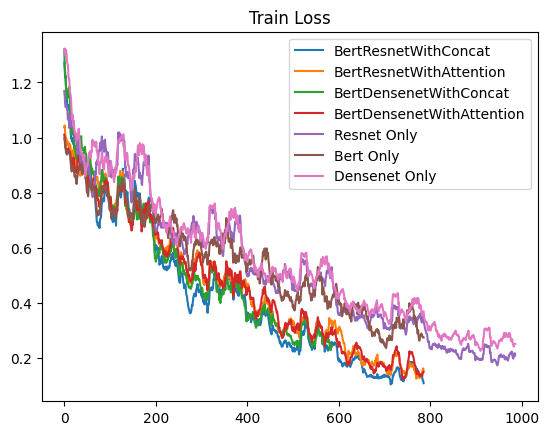

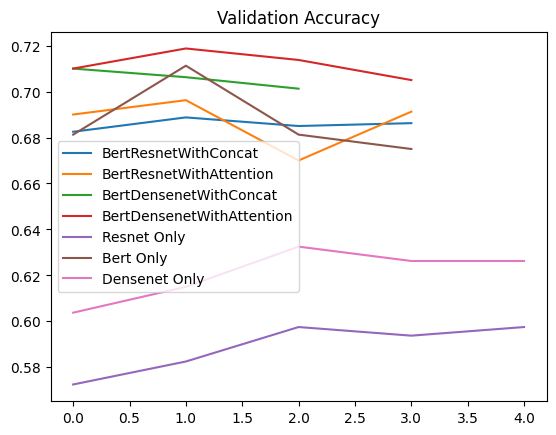

In [7]:
import time

from matplotlib import pyplot as plt

if __name__ == "__main__":
    bert_resnet_with_concat = Model(model=0)

    start_time = time.time()
    bert_resnet_with_concat.train()
    end_time = time.time()

    print("Training time:", end_time - start_time)

    bert_resnet_with_attention = Model(model=1)

    start_time = time.time()
    bert_resnet_with_attention.train()
    end_time = time.time()

    print("Training time:", end_time - start_time)

    bert_densenet_with_concat = Model(model=2)

    start_time = time.time()
    bert_densenet_with_concat.train()
    end_time = time.time()

    print("Training time:", end_time - start_time)

    bert_densenet_with_attention = Model(model=3)

    start_time = time.time()
    bert_densenet_with_attention.train()
    end_time = time.time()

    print("Training time:", end_time - start_time)

    resnet = Model(model=0, ablate=1)

    start_time = time.time()
    resnet.train()
    end_time = time.time()

    print("Training time:", end_time - start_time)

    bert = Model(model=0, ablate=2)

    start_time = time.time()
    bert.train()
    end_time = time.time()

    print("Training time:", end_time - start_time)

    densenet = Model(model=2, ablate=1)

    start_time = time.time()
    densenet.train()
    end_time = time.time()

    print("Training time:", end_time - start_time)

    plt.plot(bert_resnet_with_concat.train_loss, label="BertResnetWithConcat")
    plt.plot(bert_resnet_with_attention.train_loss, label="BertResnetWithAttention")
    plt.plot(bert_densenet_with_concat.train_loss, label="BertDensenetWithConcat")
    plt.plot(bert_densenet_with_attention.train_loss, label="BertDensenetWithAttention")
    plt.plot(resnet.train_loss, label="Resnet Only")
    plt.plot(bert.train_loss, label="Bert Only")
    plt.plot(densenet.train_loss, label="Densenet Only")
    plt.title("Train Loss")
    plt.legend()
    plt.show()

    plt.plot(bert_resnet_with_concat.val_accuracy, label="BertResnetWithConcat")
    plt.plot(bert_resnet_with_attention.val_accuracy, label="BertResnetWithAttention")
    plt.plot(bert_densenet_with_concat.val_accuracy, label="BertDensenetWithConcat")
    plt.plot(
        bert_densenet_with_attention.val_accuracy, label="BertDensenetWithAttention"
    )
    plt.plot(resnet.val_accuracy, label="Resnet Only")
    plt.plot(bert.val_accuracy, label="Bert Only")
    plt.plot(densenet.val_accuracy, label="Densenet Only")
    plt.title("Validation Accuracy")
    plt.legend()
    plt.show()

In [8]:
import time

if __name__ == "__main__":
    model = Model(model=3)

    start_time = time.time()
    model.train()
    end_time = time.time()

    print("Training time:", end_time - start_time)
    model.save_test_result()

===== Data Info =====
tag
positive    2388
negative    1193
neutral      419
Name: count, dtype: int64

Train size: 3200
Val size: 800
Test size: 511 

Loading dataset...

===== Traning Info =====
Device: cuda
Batch size: 16
Model: BertDensenetWithCrossAttention

==== Starting Train ====


100%|██████████| 200/200 [02:00<00:00,  1.66it/s]


Train Epoch 1
Train set: 
Loss: 0.8182583798468113, Accuracy: 0.6365625
Valid set: 
Loss: 0.7047787576913833, Accuracy: 0.71, Precision: 0.7028286432737554, Recall: 0.5622351379292186, F1: 0.5573259647448802


100%|██████████| 200/200 [01:59<00:00,  1.67it/s]


Train Epoch 2
Train set: 
Loss: 0.5425574917346239, Accuracy: 0.7828125
Valid set: 
Loss: 0.7118367427587509, Accuracy: 0.71875, Precision: 0.643425979876645, Recall: 0.5804123219000118, F1: 0.584184987464747


100%|██████████| 200/200 [01:59<00:00,  1.67it/s]


Train Epoch 3
Train set: 
Loss: 0.3441022937744856, Accuracy: 0.874375
Valid set: 
Loss: 0.8002323782444001, Accuracy: 0.71375, Precision: 0.6378357020303, Recall: 0.5884065006642273, F1: 0.5965659441596906


100%|██████████| 200/200 [01:59<00:00,  1.67it/s]


Train Epoch 4
Train set: 
Loss: 0.18960339413955807, Accuracy: 0.940625
Valid set: 
Loss: 0.8699598011374473, Accuracy: 0.705, Precision: 0.6143803026051361, Recall: 0.5707453693310163, F1: 0.5840671301984707
Early stop...
The training epoch is 4
Choose model with best accuracy: 0.71875, with:
Precision: 0.643425979876645
Recall: 0.5804123219000118
F1: 0.584184987464747
Training time: 573.195264339447
Predict and save test result...


100%|██████████| 32/32 [00:14<00:00,  2.20it/s]

Save successfully!
